# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set(style="ticks", context="paper")

In [3]:
from bernstein_paper.util.visualization import plot_patches

# Function Definition

In [16]:
import os

from functools import partial

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from bernstein_paper.data.dataset import WindowedTimeSeriesDataSet
from bernstein_paper.data.splitter import TimeSeriesSplit


def load_data(data_path: str,
              history_size,
              horizon_size,
              historic_columns=['load', 'is_holiday', 'tempC'],
              horizon_columns=['is_holiday', 'tempC'],
              prediction_columns=['load'],
              splits=['train', 'validate', 'test'],
              shift=None,
              validation_split=None,
              batch_size=32,
              cycle_length=10,
              shuffle_buffer_size=1000,
              seed=42):
    """
    Loads the preprocessed CER data and build the dataset.

    :param      data_path:            The path to the folder containing the
                                      train.csv and test.csv
    :type       data_path:            str
    :param      history_size:         The number of time steps of the historic
                                      data a patch should contain
    :type       history_size:         int
    :param      horizon_size:         The number of time steps in the
                                      prediction horizon a step should contain
    :type       horizon_size:         int
    :param      historic_columns:     The column names to used as historic
                                      data.
    :type       historic_columns:     Array
    :param      horizon_columns:      The column names to be used as horizon
                                      data.
    :type       horizon_columns:      Array
    :param      prediction_columns:   The columns to predict
    :type       prediction_columns:   Array
    :param      splits:               The data splits to be generated. At least
                                      one of 'train', 'validate' or 'test'
    :type       splits:               Array
    :param      shift:                The amount of time steps by which the
                                      window moves on each iteration
    :type       shift:                int
    :param      validation_split:     The amount of data reserved from the
                                      training set for validation
    :type       validation_split:     float
    :param      batch_size:           The batch size
    :type       batch_size:           int
    :param      cycle_length:         The number of input elements that are
                                      processed concurrently
    :type       cycle_length:         int
    :param      shuffle_buffer_size:  The shuffle buffer size
    :type       shuffle_buffer_size:  int
    :param      seed:                 The seed used by the pseudo random
                                      generators
    :type       seed:                 int

    :returns:   A dict containing the windowed TensorFlow datasets generated
                from csv file in `data_path` for the given `spits`.
    :rtype:     dict
    """

    # common ##################################################################
    data = {}

    scalers = {
        'load': MinMaxScaler(feature_range=(0, 1)),
        #'tempC': MinMaxScaler(feature_range=(-1, 1)),
        'weekday': OneHotEncoder(),
        'is_holiday': MinMaxScaler(feature_range=(0, 1))
    }

    column_transformer = make_column_transformer(
        *[(scalers[k], [k]) for k in sorted(scalers.keys())])

    make_dataset = partial(WindowedTimeSeriesDataSet,
                           column_transformer=column_transformer,
                           history_size=history_size,
                           horizon_size=horizon_size,
                           historic_columns=historic_columns,
                           horizon_columns=horizon_columns,
                           prediction_columns=prediction_columns,
                           shift=shift,
                           batch_size=32,
                           cycle_length=cycle_length,
                           shuffle_buffer_size=shuffle_buffer_size,
                           seed=seed)

    # train data ##############################################################
    if 'train' in splits:
        if validation_split is not None:
            data_splitter = TimeSeriesSplit(
                1 - validation_split, TimeSeriesSplit.LEFT)
        else:
            data_splitter = None
        train_data_path = os.path.join(data_path, 'train.csv')

        data['train'] = make_dataset(file_path=train_data_path,
                                     data_splitter=data_splitter,
                                     fit_transformer=True)()

    # validation data #########################################################
    if 'validate' in splits and validation_split is not None:
        data_splitter = TimeSeriesSplit(
            validation_split, TimeSeriesSplit.RIGHT)

        data['validate'] = make_dataset(file_path=train_data_path,
                                        data_splitter=data_splitter)()

    # test data ###############################################################
    if 'test' in splits:
        test_data_path = os.path.join(data_path, 'test.csv')
        data['test'] = make_dataset(file_path=test_data_path)()

    return data


# Load Dataset

In [24]:
data_path="../../data/CER Electricity Revised March 2012/preprocessed/mini/"

In [29]:
test_csv=pd.read_csv(
    os.path.join(data_path,'test.csv'),
    parse_dates=['date_time'],
    infer_datetime_format=True,
    index_col=['date_time'],
    dtype={'id': 'uint16',
           'load': 'float32',
           'is_holiday': 'uint8',
           'weekday': 'uint8'})

In [53]:
#ref.: https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
def encode(data, cycl_name):
    cycl = getattr(data.index, cycl_name)
    cycl_max = cycl.max()
    data[cycl_name + '_sin'] = np.float32(np.sin(2 * np.pi * cycl/cycl_max))
    data[cycl_name + '_cos'] = np.float32(np.cos(2 * np.pi * cycl/cycl_max))
    return data

In [54]:
test_csv = encode(test_csv, 'hour')
test_csv = encode(test_csv, 'minute')
test_csv = encode(test_csv, 'day')
test_csv = encode(test_csv, 'month')

In [84]:
test_csv.dtypes,test_csv.shape

(id             uint16
 load          float32
 is_holiday      uint8
 weekday         uint8
 hour_sin      float32
 hour_cos      float32
 minute_sin    float32
 minute_cos    float32
 day_sin       float32
 day_cos       float32
 month_sin     float32
 month_cos     float32
 dtype: object,
 (1062864, 12))

In [85]:
test_csv.head()

,id,load,is_holiday,weekday,hour_sin,hour_cos,minute_sin,minute_cos,day_sin,day_cos,month_sin,month_cos
date_time,,,,,,,,,,,,
2010-11-01 00:00:00,1035,19.171,0,0,0.000000,1.000000,0.000000e+00,1.0,0.201299,0.97953,-0.5,0.866025
2010-11-01 00:30:00,1035,15.843,0,0,0.000000,1.000000,-1.133108e-15,1.0,0.201299,0.97953,-0.5,0.866025
2010-11-01 01:00:00,1035,6.561,0,0,0.269797,0.962917,0.000000e+00,1.0,0.201299,0.97953,-0.5,0.866025
2010-11-01 01:30:00,1035,5.640,0,0,0.269797,0.962917,-1.133108e-15,1.0,0.201299,0.97953,-0.5,0.866025
2010-11-01 02:00:00,1035,6.238,0,0,0.519584,0.854419,0.000000e+00,1.0,0.201299,0.97953,-0.5,0.866025


In [90]:
scalers = {
    'load': MinMaxScaler(feature_range=(0, 1)),
    #'tempC': MinMaxScaler(feature_range=(-1, 1)),
    'is_holiday': MinMaxScaler(feature_range=(0, 1)),
    'weekday': OneHotEncoder(),
}

column_transformer = make_column_transformer(
    *[(scalers[k], [k]) for k in sorted(scalers.keys())],
    remainder='passthrough'
)
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('minmaxscaler-1', MinMaxScaler(),
                                 ['is_holiday']),
                                ('minmaxscaler-2', MinMaxScaler(), ['load']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['weekday'])])

In [91]:
trafo=column_transformer.fit_transform(test_csv[test_csv.id==1035])
trafo.shape

(2928, 18)

In [92]:
trafo[3]

array([ 0.00000000e+00,  2.93936551e-01,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.03500000e+03,  2.69796759e-01,  9.62917268e-01,
       -1.13310774e-15,  1.00000000e+00,  2.01298520e-01,  9.79529917e-01,
       -5.00000000e-01,  8.66025388e-01])

In [20]:
load_data_kwds=dict(
    data_path =  data_path,
    history_size =  48*7,
    horizon_size =  48*1,
    shift =  48*1,
    historic_columns =  ['load', 'is_holiday'],
    horizon_columns =  ['is_holiday', 'weekday'],
    prediction_columns =  ['load'],
    validation_split =  0.1,
    batch_size =  32,
    cycle_length =  10,
    shuffle_buffer_size =  100,
    seed =  1
)

In [21]:
data_sets=load_data(**load_data_kwds)
data_sets

{'train': <CacheDataset shapes: ((None, 384, 3), (None, 48, 1)), types: (tf.float32, tf.float32)>,
 'validate': <CacheDataset shapes: ((None, 384, 3), (None, 48, 1)), types: (tf.float32, tf.float32)>,
 'test': <CacheDataset shapes: ((None, 384, 3), (None, 48, 1)), types: (tf.float32, tf.float32)>}

In [22]:
train_data = data_sets['train']

In [23]:
x,y = next(train_data.as_numpy_iterator())
x.shape,y.shape

InvalidArgumentError: ValueError: `generator` yielded an element of shape (20496, 9) where an element of shape (None, 3) was expected.
Traceback (most recent call last):

  File "/home/marcel/miniconda3/envs/tfgpu/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 244, in __call__
    ret = func(*args)

  File "/home/marcel/miniconda3/envs/tfgpu/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 302, in wrapper
    return func(*args, **kwargs)

  File "/home/marcel/miniconda3/envs/tfgpu/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 861, in generator_py_func
    raise ValueError(

ValueError: `generator` yielded an element of shape (20496, 9) where an element of shape (None, 3) was expected.


	 [[{{node PyFunc}}]]

# Plot Examples

In [10]:
def sample_and_plot(x_vdim,
                    x_hdim,
                    y_vdim,
                    y_hdim,
                    N=2,
                    historic_columns=['load','is_holiday'],
                    horizon_columns=['is_holiday'],
                    prediction_columns=['load'],
                    **kwds):

    history_size=x_vdim*x_hdim
    horizon_size=y_vdim*y_hdim
    shift =  horizon_size

    columns = set(historic_columns + horizon_columns + prediction_columns)
    
    idx={k:i for i,k in enumerate(columns)}
    
    height_ratios=[len(set(historic_columns + horizon_columns))*(np.where(len(historic_columns),x_vdim,0)+np.where(len(horizon_columns),y_vdim,0)),
                   len(prediction_columns)*y_vdim]

    fig_height=sum(height_ratios) + min(len(historic_columns),1) + min(len(prediction_columns),1)
    fig_height/=5
    fig_width=N*(max(x_hdim, y_hdim) + min(N-1,1))/7

    ds = load_data(
        data_path =  data_path,
        history_size =  history_size,
        horizon_size =  horizon_size,
        shift =  shift,
        historic_columns =  historic_columns,
        horizon_columns =  horizon_columns,
        prediction_columns =  prediction_columns,
        splits = ['train'],
        shuffle_buffer_size = 0,
        seed = 1,
        **kwds
    )['train']
    
    plot_patches(ds,
                 N=N,
                 x_hdim=x_hdim,
                 x_vdim=x_vdim,
                 y_hdim=y_hdim,
                 y_vdim=y_vdim,
                 historic_columns=historic_columns,
                 horizon_columns=horizon_columns,
                 prediction_columns =  prediction_columns,
                 title_map = {'x':'Input Data',
                              'y':'Prediction Target'},
                 y_label_map = {'x':{
                                  'is_holiday':'Is Holiday',
                                  'load':'Load'},
                                'y':{
                                  'load':'Load'}},
                 fig_kw={'figsize':(fig_width,fig_height)},
                 heatmap_kw={'x':{
                                 'is_holiday':{'cmap':'binary'},
                                 'load':{'cmap':'OrRd'}},
                             'y':{
                                 'load':{'cmap':'OrRd'}}},
                 gridspec_kw={'height_ratios':height_ratios,
                              'hspace':2/fig_height,
                              'wspace':1/fig_width},
                 xy_ch_connect=(
                     ('load', 0),
                     ('load', x_vdim + y_vdim - 1 - shift // x_hdim)))

In [11]:
x_vdim=7
x_hdim=48
y_vdim=1
y_hdim=48

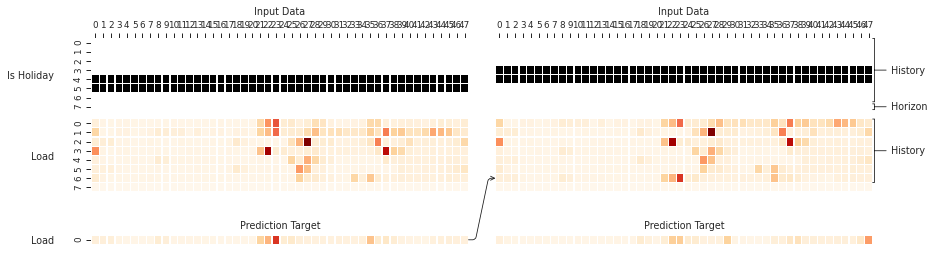

In [12]:
sample_and_plot(
    x_vdim=x_vdim,
    x_hdim=x_hdim,
    y_vdim=y_vdim,
    y_hdim=y_hdim,
    batch_size=3,
    cycle_length=1)

# Benchmark

In [13]:
import time
from tqdm.notebook import tqdm

In [14]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in trange(num_epochs):
        epoch_start_time = time.perf_counter()
        for sample in tqdm(dataset):
            # Performing a training step
            #time.sleep(0.0001)
            pass
        print(f"Epoch {epoch_num} execution time:",
              time.perf_counter() - epoch_start_time)
    print("Execution time:", time.perf_counter() - start_time)

In [15]:
benchmark(train_data)

NameError: name 'trange' is not defined